# Transfer learning para identificação de objetos  

- Neste projeto, vamos utilizar uma rede neural pré-treinada chamada MobileNet
- Utilizaremos a base de dados TensorFlow Flowers 
- Código baseado na documentação abaixo: 
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras


**Importação das bibliotecas**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

In [2]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importação do modelo pré-treinado**

In [3]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url,
                                                        input_shape = (224, 224, 3))])

**Testes com o modelo pré-treinado**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

In [7]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/bicycle.png',
                                                     target_size = (224, 224))


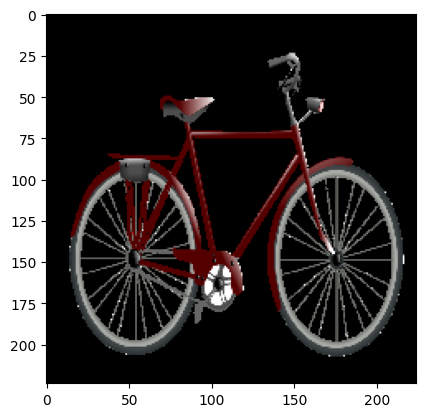

In [8]:
plt.imshow(sample_image)

In [9]:
sample_image = np.array(sample_image) / 255.0

In [10]:
sample_image.shape

(224, 224, 3)

In [11]:
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

1/1 [==============================] - 8s 8s/step


In [12]:
predicted_class

array([[ 0.28730837,  0.46231276, -0.02627148, ..., -1.0349276 ,
         0.34823972, -0.04379682]], dtype=float32)

In [13]:
len(predicted_class[0])

1001

In [14]:
predicted_class.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(predicted_class)
predicted_class

672

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


In [17]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [18]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [19]:
len(imagenet_labels)

1001

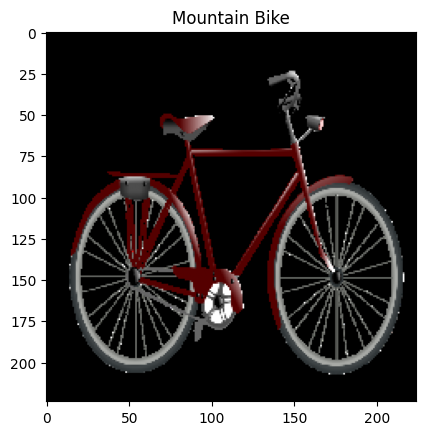

In [20]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

**Testes com um conjunto de imagens**

In [21]:
flowers_data_url = tf.keras.utils.get_file('flower_photos', 
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

228813984/228813984 [==============================] - 10s 0us/step


In [26]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size = (224, 224),
                                                  batch_size = 64,
                                                  shuffle = True)                                                            

Found 3670 images belonging to 5 classes.


In [27]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print('Image batch shape: ', flowers_data_input_batch.shape)
  print('Label batch shape: ', flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [28]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

2/2 [==============================] - 1s 20ms/step


(64, 1001)

In [29]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis = -1)]
predicted_class_names

array(['daisy', 'spider web', 'picket fence', 'volcano', 'picket fence',
       'rapeseed', 'daisy', 'pot', 'daisy', 'pinwheel', 'cardoon',
       'rapeseed', 'hip', 'daisy', 'wool', 'picket fence', 'daisy', 'bee',
       'ostrich', 'daisy', 'vase', 'clog', 'feather boa', 'daisy',
       'daisy', 'picket fence', 'bee', 'daisy', 'daisy', 'rapeseed',
       'goldfish', 'bubble', 'balloon', 'sea urchin', 'vault', 'vase',
       'picket fence', 'barn', 'bee', 'daisy', 'daisy', 'cucumber',
       'American egret', 'feather boa', 'daisy', 'sea urchin', 'daisy',
       'ladybug', 'tray', 'bee', 'hummingbird', 'pot', 'barn spider',
       'artichoke', 'picket fence', 'greenhouse', 'mushroom', 'barrow',
       'daisy', 'head cabbage', 'barn spider', 'fountain', 'wooden spoon',
       'coil'], dtype='<U30')

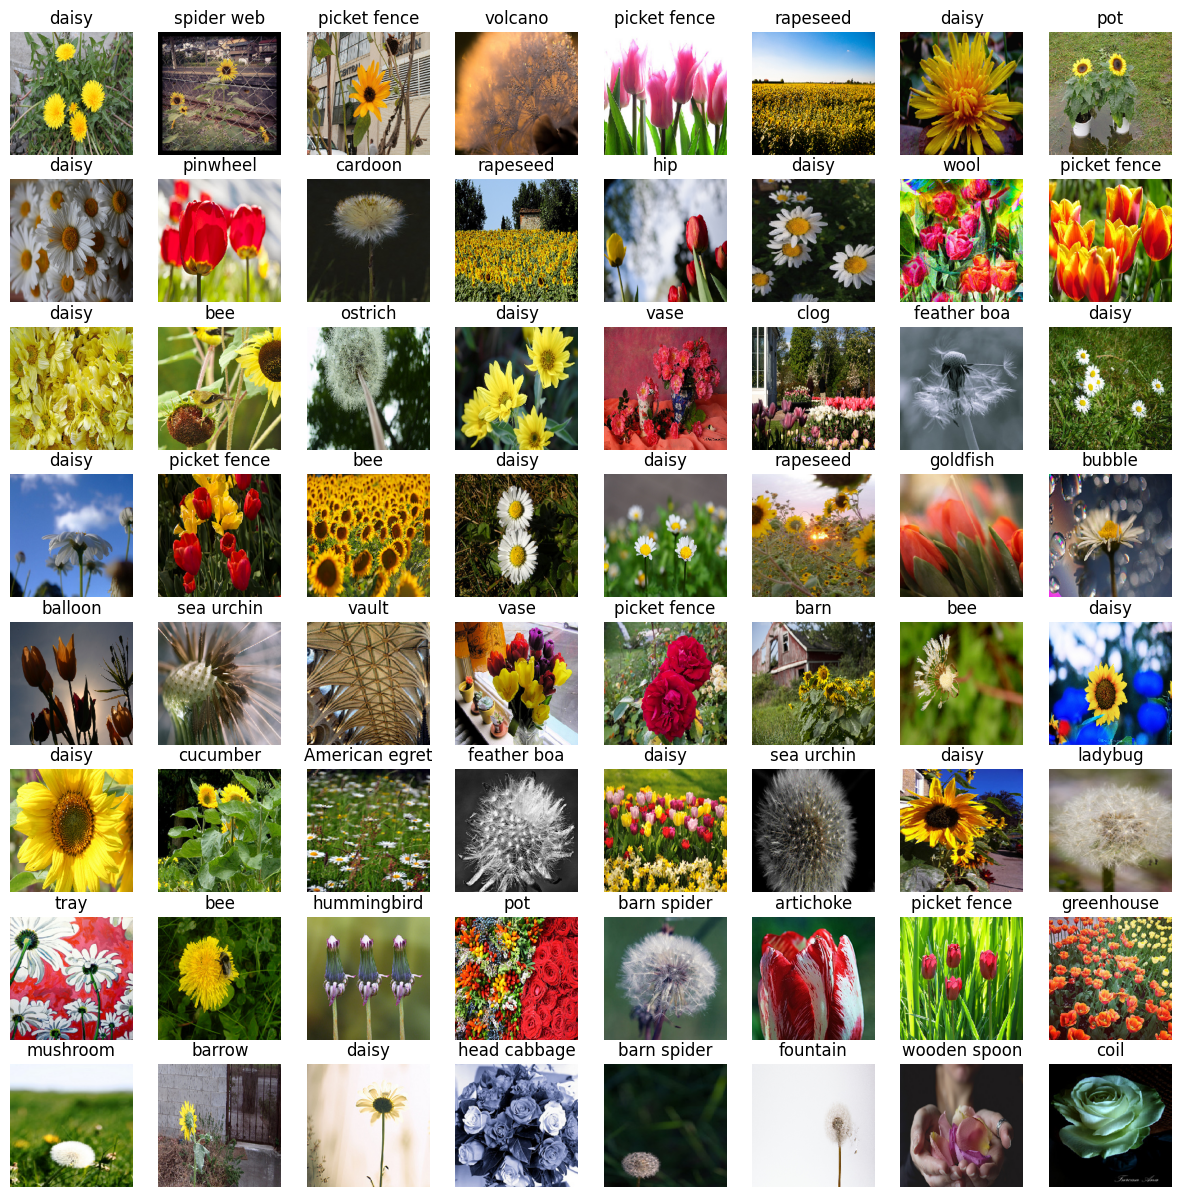

In [30]:
plt.figure(figsize = (15, 15))
for n in range(64):
  plt.subplot(8, 8, n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

**Transfer learning**

Download do MobileNet sem o topo do modelo:
https://tfhub.dev/s?module-type=image-feature-vector&q=tf2


In [31]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [32]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape = (224,224, 3))

In [35]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [36]:
MobileNet_feature_extractor_layer.trainable = False

In [37]:
flower_data.num_classes

5

In [39]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation = 'softmax')])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [43]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [44]:
history = model.fit_generator(flower_data, epochs = 50)

<ipython-input-44-4df3f6e3424b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(flower_data, epochs = 50)


Epoch 1/50
58/58 [==============================] - 21s 299ms/step - loss: 0.7574 - accuracy: 0.7379
Epoch 2/50
58/58 [==============================] - 18s 305ms/step - loss: 0.3771 - accuracy: 0.8714
Epoch 3/50
58/58 [==============================] - 18s 300ms/step - loss: 0.3052 - accuracy: 0.8978
Epoch 4/50
58/58 [==============================] - 17s 293ms/step - loss: 0.2600 - accuracy: 0.9172
Epoch 5/50
58/58 [==============================] - 17s 294ms/step - loss: 0.2301 - accuracy: 0.9272
Epoch 6/50
58/58 [==============================] - 17s 293ms/step - loss: 0.2042 - accuracy: 0.9376
Epoch 7/50
58/58 [==============================] - 17s 292ms/step - loss: 0.1858 - accuracy: 0.9469
Epoch 8/50
58/58 [==============================] - 17s 287ms/step - loss: 0.1557 - accuracy: 0.9605
Epoch 10/50
58/58 [==============================] - 17s 290ms/step - loss: 0.1453 - accuracy: 0.9624
Epoch 11/50
58/58 [==============================] - 18s 304ms/step - loss: 0.1324 - accur

**Avaliação do modelo**

In [45]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [46]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [47]:
class_names = np.array([key.title() for key, value in class_names])

In [48]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [49]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

2/2 [==============================] - 0s 43ms/step


In [50]:
predicted_id

array([1, 3, 3, 1, 4, 3, 1, 3, 0, 4, 1, 3, 4, 0, 4, 4, 3, 3, 1, 3, 2, 4,
       1, 0, 0, 4, 3, 0, 0, 3, 4, 0, 4, 1, 2, 4, 2, 3, 1, 3, 3, 3, 0, 1,
       4, 1, 3, 1, 0, 1, 1, 2, 1, 4, 4, 4, 1, 3, 0, 2, 1, 1, 2, 2])

In [51]:
predicted_label_batch

array(['Dandelion', 'Sunflowers', 'Sunflowers', 'Dandelion', 'Tulips',
       'Sunflowers', 'Dandelion', 'Sunflowers', 'Daisy', 'Tulips',
       'Dandelion', 'Sunflowers', 'Tulips', 'Daisy', 'Tulips', 'Tulips',
       'Sunflowers', 'Sunflowers', 'Dandelion', 'Sunflowers', 'Roses',
       'Tulips', 'Dandelion', 'Daisy', 'Daisy', 'Tulips', 'Sunflowers',
       'Daisy', 'Daisy', 'Sunflowers', 'Tulips', 'Daisy', 'Tulips',
       'Dandelion', 'Roses', 'Tulips', 'Roses', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Sunflowers', 'Sunflowers', 'Daisy', 'Dandelion',
       'Tulips', 'Dandelion', 'Sunflowers', 'Dandelion', 'Daisy',
       'Dandelion', 'Dandelion', 'Roses', 'Dandelion', 'Tulips', 'Tulips',
       'Tulips', 'Dandelion', 'Sunflowers', 'Daisy', 'Roses', 'Dandelion',
       'Dandelion', 'Roses', 'Roses'], dtype='<U10')

In [52]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([1, 3, 3, 1, 4, 3, 1, 3, 0, 4, 1, 3, 4, 0, 4, 4, 3, 3, 1, 3, 2, 4,
       1, 0, 0, 4, 3, 0, 0, 3, 4, 0, 4, 1, 2, 4, 2, 3, 1, 3, 3, 3, 0, 1,
       4, 1, 3, 1, 0, 1, 1, 2, 1, 4, 4, 4, 1, 3, 0, 2, 1, 1, 2, 2])

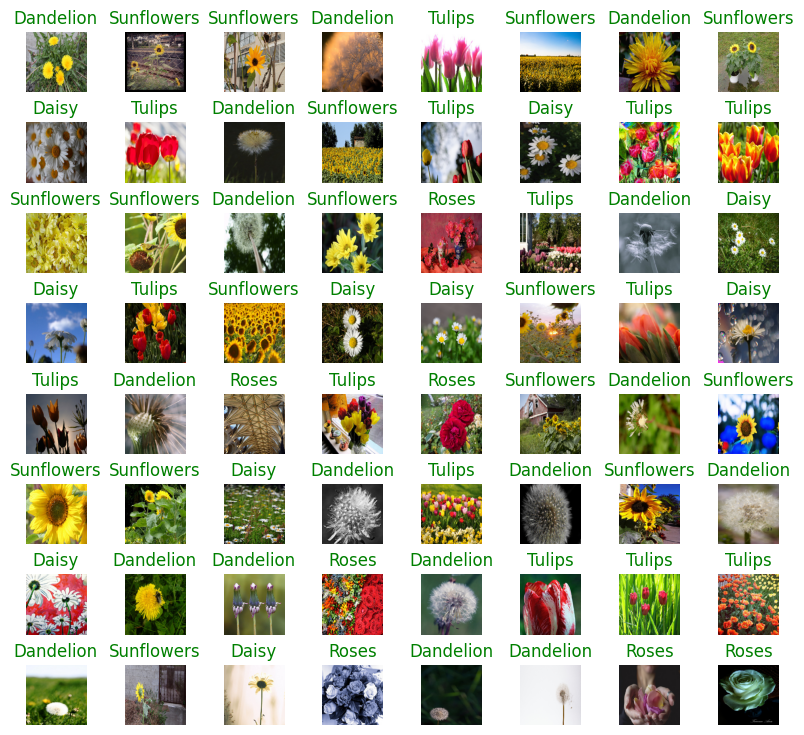

In [53]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')